*Disclaimer: this is not an offical Digital Earth Africa notebook*

<div class="alert alert-block alert-info">

<b>BLUE:</b> These represent additional information to the user of the notebook.
</div>

<div class="alert alert-block alert-danger">  
    
<b>RED:</b> These are warnings to the user of the notebook.
</div>

<div class="alert alert-block alert-warning">
    
<b>ORANGE:</b> These are questions and requests for help.
</div>

# Coastal Inundation Tool

* **Products used:**
[strm 1 second elevation model](https://explorer.digitalearth.africa/products/srtm) and [Water Observation from Space (WOfS) annual summary](https://explorer.digitalearth.africa/products/ga_ls8c_wofs_2_annual_summary/extents)

<div class="alert alert-block alert-info"><b>NOTE:</b></div>

> This notebook is one of a companion piece and focuses on coastal inundation as a result of storm surges. The other is titled [River and Urban Flooding](https://github.com/AdrianKriger/deafrica-sandbox-notebooks/blob/master/Real_world_examples/River_and_Urban_Flooding.ipynb) and focuses on flooding of inland urban areas.

### Background

Coastal Inundation can be defined as the flooding of dry or low-lying land by seawater. It occurs when seawaters breach the topography of coastal areas and penetrate inland. 

Although coastal flooding is largely a natural event its destructive consequences have been increasing. This phenomenon is being fueled by both an increase in population rates and more frequent extreme weather events caused by anthropogenic climate change. Coastal Inundation affects 50% of the global population which live along the coastal zone. Lives, homes, infrastructure and business are all at risk of coastal inundation with massive Social and Economic costs. Flooding of coastal areas also destroys habitats rich in diversity. Biodiversity and habitat loss including salt water intrusion affecting agricultural land and fresh water supply are further Environmental, Social and Economic impacts. Flooding is not directly addressed in the [*Sustainable Development Goals*](https://www.un.org/sustainabledevelopment/sustainable-development-goals/) but it is significant to achieving [No Poverty (Goal 1)](https://www.un.org/sustainabledevelopment/poverty/), Ensuring [Good Health and Wellbeing for All (Goal 3)](https://www.un.org/sustainabledevelopment/health/), [Clean Water and Sanitation (Goal 6)](https://www.un.org/sustainabledevelopment/water-and-sanitation/), [Sustainable Cities and Communities (Goal 11)](https://www.un.org/sustainabledevelopment/cities/) and [Life on Land (Goal 15)](https://www.un.org/sustainabledevelopment/biodiversity/). *([a recent paper highlights how flooding relates to the Sustainable Development Goals within Nigeria](https://www.tandfonline.com/doi/full/10.1080/20964129.2020.1791735))*

The `Coastal Inundation Tool (CiT)` is different from empirical methods and hydrodynamic models which are widely applied in flood inundation modelling. The `CiT` provides at a glance insights into coastal dynamics. The `CiT` is a summary that investigates the [srtm elevation](https://explorer.digitalearth.africa/products/srtm) and [Water Observation from Space (WOfS)](https://explorer.digitalearth.africa/products/ga_ls8c_wofs_2_annual_summary/extents) datasets held within Digital Earth Africa (DE Africa). `Elevation` data is retrieved from DE Africa and extracted to produce a water mask, which is refined with the WOfS, to describe the possible flooding during storm surge events.  

<!-- > `Detailed Explanation:`-->
<!--Data ... time.-->

### Description
This notebook will run the Coastal Inundation Tool for an area of interest. We extract elevation profiles related to inundation senarios. And overlay flood masks to visualize the potential impact.


1.  Load in the srtm
2.  Extract Area of Interest
3.  Run the Coastal Inundation Tool
4.  Plot the results
5.  Overlay and visualize the result.
6.  Export inundation polygons (masks).

<!-- 6.  Validate  -->
<!-- 7.  Generate a second animation comparing the per-pixel classification to the true colour timeseries -->
***

> **Note:** This notebook goes further and investigates an actual event. Tropical Cyclone Idai made landfall near **Beira city, Mozambique on 15 March 2019** with devastaing consequences. Unfortunately due to the nature of the event DE Africa *optical datasets* cannot penetrate the clouds following such weather. To test the effectiveness of this tool [Sentinel 1 Synthetic Aperture Radar (SAR)](https://sentinel.esa.int/web/sentinel/sentinel-data-access) was sourced and processed to compare predicted with actual data.

## Getting started
**To execute this analysis**, run all the cells in the notebook, starting with the **Load packages** cell.

**After finishing the notebook**, return to the **Analysis parameters** cell, modify some values *(e.g. choose a different area of interest)* and re-run the analysis.
There are additional instructions on modifying the notebook at the end.

***

### Load packages

In [9]:
%matplotlib inline

import sys
import datacube
#from datacube.storage import masking
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

from scipy import ndimage

from osgeo import gdal

sys.path.append('../Scripts')
from deafrica_spatialtools import xr_vectorize
from deafrica_plotting import display_map, rgb
from datacube.utils.cog import write_cog
from deafrica_datahandling import load_ard, wofs_fuser
#from datacube.storage.masking import make_mask
#from deafrica_dask import create_local_dask_cluster

#This will speed up loading data
#datacube.utils.rio.set_default_rio_config(aws='auto', cloud_defaults=True)

### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app='Coastal_Inundation_Tool')

### Analysis parameters 

The following cell sets important parameters for the analysis:

- lat: The central longitude to analyse (e.g. 34.70).
- lon: The central latitude to analyse (e.g. -19.85).
- buffer: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as 0.1 or lower.

**If running the notebook for the first time**, keep the default settings below. This will demonstrate how the analysis works and provide meaningful results. The example generates inundation polygons (masks) for an area near Beira city, Mozambique.

In [4]:
# Define the central point of the area of interest
lat, lon = -19.85, 34.70

# buffer will define the upper and lower boundary from the central point
buffer = 0.1   

# Combine central lat, lon with buffer to get area of interest
lat_range = (lat - buffer, lat + buffer)
lon_range = (lon - buffer, lon + buffer)

### View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point

In [5]:
display_map(x=(lon - buffer, lon + buffer), y=(lat + buffer, lat - buffer))

## Load elevation data

To evaluate Coastal Inundation, we first need to obtain an elevation dataset. DE Africa's datacube contains a Digital Elevation Model (DEM) from the [Shuttle Radar Topography Mission (SRTM)](https://lpdaac.usgs.gov/documents/13/SRTM_Quick_Guide.pdf). We can load in elevation data directly from the datacube using `dc.load`.

The Shuttle Radar Topography Mission NASA JPL Version 3.0 *(“SRTM Plus”)* is void filled with non-commercial ASTER GDEM2, GMTED2010, and NED, to produce a 1 arc-second (~30m) product.

<div class="alert alert-block alert-danger">
    
<b>WARNING:</b> This elevation dataset is not hydrologically correct and is not meant for hydraulic analysis. To ensure quality analysis standard practice recommends processing before any investigation. We only perform basic 'smoothing'. Our result thus serves as a guide to inform further study.</div>

In [6]:
# Create a dem reusable query
dem_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:2736',    # utm36s
    'resolution': (-30, 30)
}

#load elevation
elevation_array = dc.load(product ='srtm', **dem_query)
elevation_array

<xarray.Dataset>
Dimensions:      (time: 1, x: 706, y: 746)
Coordinates:
  * time         (time) datetime64[ns] 2019-09-09
  * y            (y) float64 7.816e+06 7.816e+06 ... 7.793e+06 7.793e+06
  * x            (x) float64 6.675e+05 6.675e+05 ... 6.886e+05 6.886e+05
    spatial_ref  int32 2736
Data variables:
    elevation    (time, y, x) int16 8 8 8 7 5 5 4 4 4 6 ... 0 0 0 0 0 0 0 0 0 0
Attributes:
    crs:           EPSG:2736
    grid_mapping:  spatial_ref

Once the load is complete, the last `elevation_array` parameter printed it. The returned `xarrayDataset` has a single entry in the `time` dimension. To make the data easier to work with, we convert it to a `dataArray`.

In [11]:
#convert to an dataArray (rather an Dataset) and select single time-slice
dem30 = elevation_array[['elevation']].isel(time=0).to_array()

### Smoothing

Due to the nature of the SRTM product we must *smooth* the surface before an investigation can yield a quality result.

We apply a `scipy.ndimage.median_filter()` to resolve local outliers and `scipy.ndimage.gaussian_filter()` to reduce noise and detail.

In [12]:
# median_filter with 7x7 kernel size
demMF = ndimage.median_filter(dem30.squeeze(), size=7, mode='mirror')

nu_passes = 3
sigma = 2
truncate = 1.25

dem = demMF
#or without the median ~
#dem = dem30.squeeze()

for i in range(nu_passes):
    dem = ndimage.gaussian_filter(dem, sigma=sigma, mode='mirror', truncate=truncate)
    
#create a DataArray object
dem = xr.DataArray(data = dem.squeeze(),
                   coords = {'y': dem30.y, 
                             'x': dem30.x},
                             #'spatial_ref': 2736},
                   #attrs = {'crs': 'EPSG:2736'},
                   dims = ["y", "x"])

### Plot the *'smooth'* data

We can plot the elevation data for the region using a custom colour map:

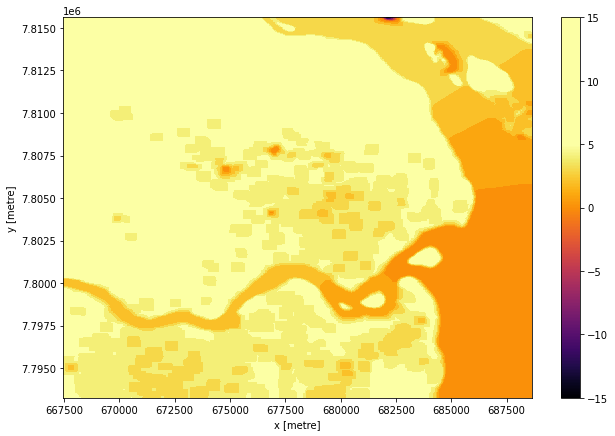

In [13]:
# Create a custom colourmap for the DEM
colors_terrain = plt.cm.inferno(np.linspace(0.0, 1.5, 25))
cmap_terrain = mpl.colors.LinearSegmentedColormap.from_list('inferno', colors_terrain)

# Plot a subset of the elevation data
dem.plot(size=7, cmap=cmap_terrain)
plt.show()

### Histogram

An extremely effective method of exploring the distribution of elevation values is a histogram.

We extend the basic `matplotlib` `.hist` function and apply our previously generated `colormap`. This way the histogram *(the distribution)* matches the plot above.

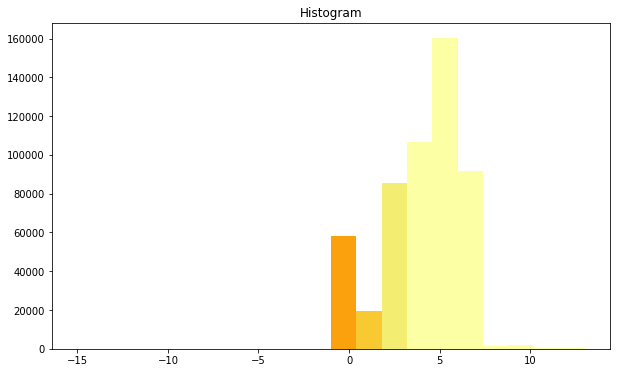

In [14]:
# Plot a histogram
f, ax = plt.subplots(figsize=(10, 6))

# Plot histogram.
n, bins, patches = dem.squeeze().plot.hist(ax=ax,
                                           color="purple",
                                           bins=20)                 # 20 bins might be a bit much for coastal arears
bin_centers = 0.8 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap_terrain(c))

plt.show()

The histogram above represents the distibution of elevation values in our data. It provides a shapshot of our area of interest and is usefull because: 

   * We can easily identify outliers;  
   * Quickly determine the `min` and `max` values;  
   * Explore the general distribution values of the data and draw conclusions *(is the area hilly? or flat? is the area low-lying or high-lying?)*.

## Extract multiple inundation senarios

Although many methods and hydrodynamic models exist to simulate inundation this tool uses the least complex. `CiT` mimics the popular [Flood Fill](https://en.wikipedia.org/wiki/Flood_fill) image processing technique. Flood Fill determines the area connected to a given node in a multiple dimension array and is used in the *bucket* tool of paint programs to fill connected, similarly-colored areas with a different color, and in games such as **Go** and **Minesweeper** for determining which pieces are cleared. This tool thus assumes that surge water will flow to areas of the same elevation. 

We extract possible flooding senarios at 0 to 6 meters. `python` counts from zero. To extract elevations from 0 to six meters we set a range of seven.

In [15]:
flood_range = 7

Then place each elevation in a `dictionary`.

In [19]:
mask = {}

for k in range(flood_range):
    mask[k] = dem <= k

### Plot each possible water level

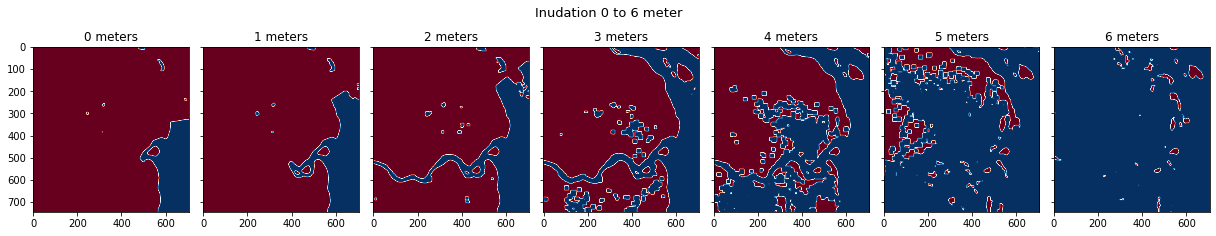

In [20]:
_, axs = plt.subplots(1, len(mask), figsize=(17, 17), sharey='row')
axs = axs.flatten()
for img, ax in zip(mask, axs):
    ax.imshow(mask[img].squeeze(), cmap='RdBu')
    ax.set_title(str(img) + ' meters')
    
plt.suptitle('Inudation 0 to 6 meter', size = 13, y = 0.6)
plt.tight_layout()
plt.show()

## Refine prediction

We can improve our prediction through excluding areas that are normally classified as water. To do so we explore the [Water Observation from Space (WOfS) annual summary](https://explorer.digitalearth.africa/products/ga_ls8c_wofs_2_annual_summary/extents) product within Digital Earth Africa. This product records how often a pixel was classified as water in a given year. Through removing these water covered areas our prediction allows us to concentrate on possible flooded areas only.

## Load WOfS annual summary

In [21]:
# Create a query
wofs_query = {
    'x': (lon_range),
    'y': (lat_range),
    'output_crs': 'EPSG:2736',    # utm36s
    'time': ('2018-01-01', '2018-12-30'),
    'resolution': (-30, 30)
}

# Load the data from the datacube
wofls = dc.load(product="ga_ls8c_wofs_2_annual_summary", group_by="solar_day",
                            fuse_func=wofs_fuser, **wofs_query)

In [22]:
wofls

<xarray.Dataset>
Dimensions:      (time: 1, x: 706, y: 746)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999500
  * y            (y) float64 7.816e+06 7.816e+06 ... 7.793e+06 7.793e+06
  * x            (x) float64 6.675e+05 6.675e+05 ... 6.886e+05 6.886e+05
    spatial_ref  int32 2736
Data variables:
    count_wet    (time, y, x) int16 0 0 0 0 0 0 0 0 0 ... 11 11 11 11 11 11 11 7
    count_clear  (time, y, x) int16 15 15 14 15 15 15 15 ... 11 11 11 11 11 11
    frequency    (time, y, x) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 0.6363636
Attributes:
    crs:           EPSG:2736
    grid_mapping:  spatial_ref

We select pixels that are classified as water 90% of the year. Feel free to explore the [Applying_WOfS_bitmasking.ipynb](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebook for a more indepth analysis.

In [23]:
mask_with90 = wofls.squeeze().frequency >= 0.9
mask_with90.values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False]])

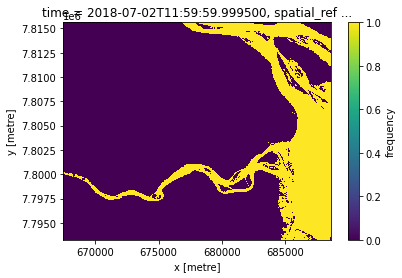

In [24]:
#plot
mask_with90.plot()

## New Inundation Senario

With our possible flooding levels and WOfS we simply create a water mask, and new refined predictions.

In [25]:
new_mask = {}

for i in range(flood_range):
    new_mask[i] = mask[i].where(wofls.squeeze().frequency <= 0.9)

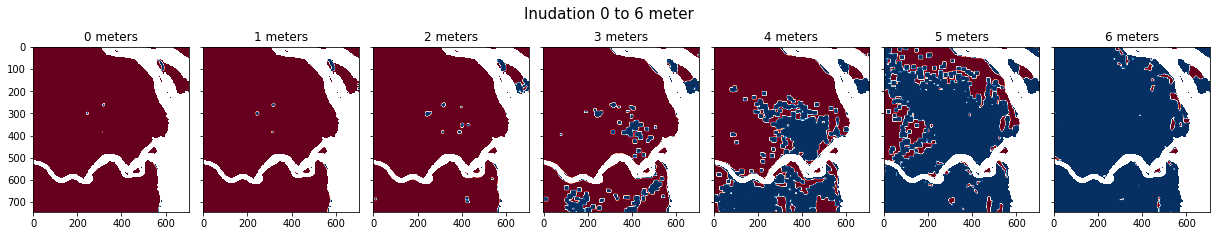

In [26]:
_, axs = plt.subplots(1, len(new_mask), figsize=(17, 17), sharey='row')
axs = axs.flatten()
for img, ax in zip(new_mask, axs):
    cb = ax.imshow(new_mask[img].squeeze(), cmap='RdBu')
    ax.set_title(str(img) + ' meters')

#plt.colorbar(cb)                                                      #perhaps a colorbar would be informative - add divider?
plt.suptitle('Inudation 0 to 6 meter', size = 15, y = 0.6)
plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning"><b>ATTENTION:</b> Have I done this correctly? Have I removed the 90% WOfS from the prediction correctly? Is there a more effective method?</div>

### Vectorize each elevation mask to a `GeoDataframe`

In the cell below, we use the argument `mask=new_mask[i].values==True` to indicate we only want to convert the values in the xarray object that are equal to 1. We also add a `vectorize_gdf['z_value'] = i` parameter to add an elevation attribute to each polygon.

> **Note:** Both `xr_rasterize` and `xr_vectorize` will attempt to automatically obtain the `crs` and `transform` from the input data, but if the data does not contain this information, you will need to manually provide it. In the cell below, we will harvest the `crs` and `transform` from the original dataset.


In [27]:
gdf = gpd.GeoDataFrame()

for i in new_mask:                                                                                         
        vectorize_gdf = xr_vectorize(new_mask[i],                                                          
                                     crs=wofls.crs,
                                     transform=wofls.geobox.transform,
                                     mask=new_mask[i].values==True)                                           
        vectorize_gdf['z_value'] = i
        gdf = gdf.append(vectorize_gdf, ignore_index=True)

This returns a `geopandas.GeoDataFrame` containing each flooding senario with the elevation given in a field named `z_value`. 

> We can query the `.unique` elevation (`z_values`) values

In [28]:
gdf.z_value.unique()

array([0, 1, 2, 3, 4, 5, 6])

> And we can query the `.head`  and `.tail` of the `GeoDataFrame`

In [29]:
gdf.tail(5)
#gdf.head(5)  # uncomment to view the head ~ but remember to # (hash) the top line

,attribute,geometry,z_value
2484,1.0,"POLYGON ((686970.000 7793370.000, 686970.000 7...",6
2485,1.0,"POLYGON ((686910.000 7793340.000, 686910.000 7...",6
2486,1.0,"POLYGON ((685680.000 7793280.000, 685680.000 7...",6
2487,1.0,"POLYGON ((686880.000 7793280.000, 686880.000 7...",6
2488,1.0,"POLYGON ((686400.000 7794090.000, 686400.000 7...",6


### Plot a selected water level over the DEM

Select an elevation between 0 and 6 meters

In [30]:
test = 4

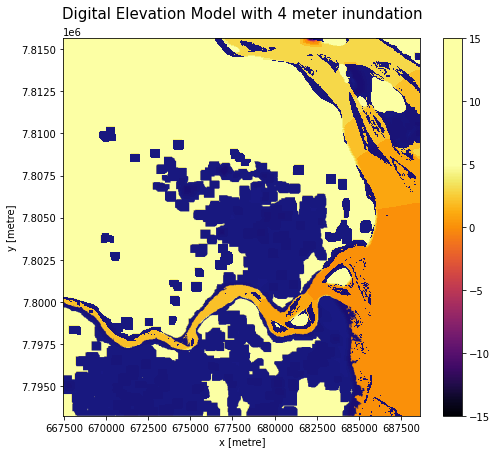

In [31]:
assert test >= 0 and test <= 7, "Values must be between 0 and 6."
    
# Plot a subset of the elevation data
fig, ax = plt.subplots(figsize=(8,6))
#fig.patch.set_alpha(0)

dem.plot(cmap=cmap_terrain, zorder=1)
gdf_plot = gdf[gdf['z_value'] == test]
gdf_plot.plot(ax=ax, zorder=2, color='navy', linewidth=0.5, alpha=0.9)
ax.set_title('Digital Elevation Model with ' +str(test)+ ' meter inundation', pad=20, fontsize=15)
plt.subplots_adjust(top=1)
plt.show()

### Export Coastal Inundation to file

The `GeoDataFrame` natively exports as a shapefile for use in other applications.

> Exporting to GeoJSON is supported through adding the `driver=` parameter ~ `gdf.to_file("CoastalInundation.geojson", driver='GeoJSON')`

In [17]:
gdf.to_file("../Supplementary_data/WorkingFolder/CoastalInundation.shp")

## 3D Surface Visualization

We can create a dynamic visualization showing possible flooding over a 3D surface.

> **NOTE**: `mpl_toolkits.mplot3d` `Axes3D` the module used to represent the DEM as a 3D surface is computationally expensive. The larger the `buffer` set at  **Analysis parameters** (`cell 3`) the longer the plot will take to render. 


/env/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Z contains NaN values. This may result in rendering artifacts.


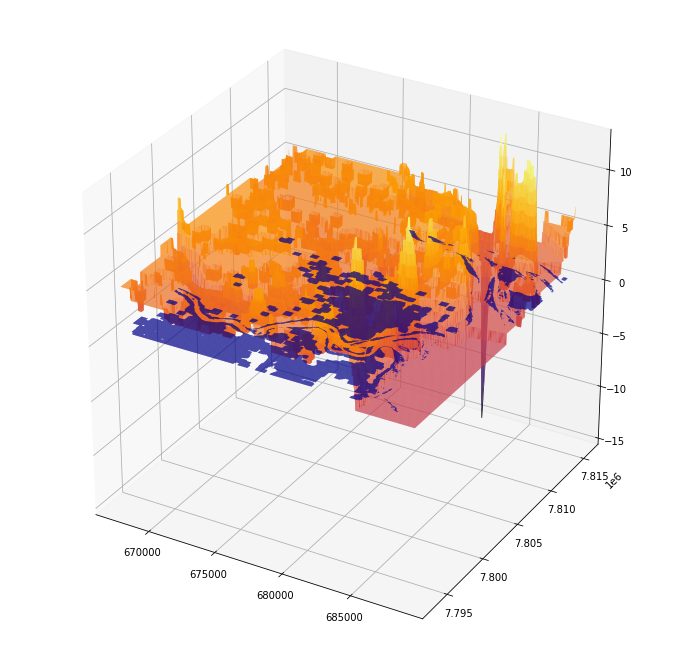

In [50]:
# set up a figure 
fig = plt.figure(figsize=(12,12))
ax = fig.gca(projection='3d')

#transform the image
xres = elevation_array.geobox.transform[0]
yres = elevation_array.geobox.transform[4]
X = np.arange(dem30.geobox.transform[2], dem30.geobox.transform[2] + dem30.shape[1:][1]*xres, xres)
Y = np.arange(dem30.geobox.transform[5], dem30.geobox.transform[5] + dem30.shape[1:][0]*yres, yres)
X, Y = np.meshgrid(X, Y)

# plot a 3D surface --- oriented North West from the bottom right corner
surf = ax.plot_surface(X, Y, dem.squeeze(), rstride=2, cstride=2, cmap='inferno', linewidth=0, antialiased=True, zorder=2)

water_m = new_mask[test].copy()
wm = water_m.fillna(test)
idx = np.where(water_m.values == 1.)
wm[idx[0][0]] = test
w = ax.plot_surface(X,Y, wm.where(wm == 1), 
                     rstride=2, cstride=2, color='b', linewidth=0, antialiased=True, zorder=2)

plt.show()

<div class="alert alert-block alert-warning"><b>ATTENTION:</b></div>
    
> How to "hard-code" and visualize only a fraction of the total analysis area? (so that the analysis area can increase in size but exploratory visualization is less computationally expensive).
    
> Overlaying the DEM with the flood level is also proving challenging. The water is not in the correct position.

## Real_world Test

In order to test the effectiveness of our tool we can compare an actual event with our prediction.

On **15 March 2019 Cyclone Idai made landfall near Beira, Mozambique.** The neighbouring nations of Madagascar, Malawi and Zimbabwe all suffered    the storms destructive power. A total of 3 million people were affected by the winds, rain and flooding that followed the storms path. Of particular concern were the outbreaks of waterbourne diseases, such as cholera, in flooded areas. Incidence of malaria caused by malarial mosquitoes breeding in stagnant flood water also increased.  Reports estimates the total cost of destruction between `$2bn` and `$1bn`. ([Wikipedia, 2020](https://en.wikipedia.org/wiki/Cyclone_Idai#Disease_outbreaks))

Optical datasets, such as [Sentinel 2](https://explorer.digitalearth.africa/products/s2_l2a) available within DE Africa, cannot penetrate the cloud-cover following an event of this nature.

We can execute a query and check.

In [43]:
# Define the start and end dates that define the search
start_year = '2019-03-11'
end_year = '2019-03-30'

#Create a query object
sen_query = {
    'x': (lon-buffer, lon+buffer),
    'y': (lat+buffer, lat-buffer),
    'resolution': (-10, 10),
    'output_crs':'EPSG:2736',
    'group_by': 'solar_day',
    'time': (start_year, end_year)
    #'dask_chunks':{'time':1,'x':1000,'y':1000}
}

In [44]:
ds_sen2 = load_ard(dc=dc,
                      products=['s2_l2a'],
                      measurements=['red', 'green', 'blue', 'nir'],
                      #min_gooddata = 0.10,
                      **sen_query)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 4 time steps


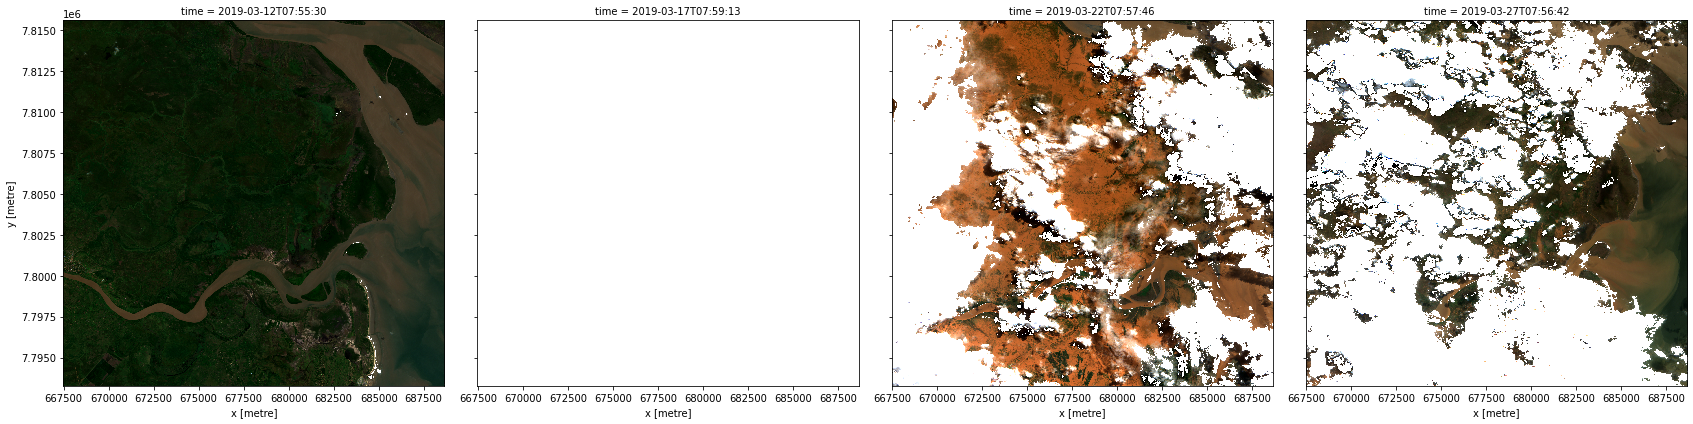

In [45]:
rgb(ds_sen2, col='time', col_wrap = 5)

Cloud cover prevents a certain evaluation after Idia's landfall (15 March).

<div class="alert alert-block alert-info">

<b>NOTE:</b> Hereafter the test with SAR is performed.</div>

### Sentinel-1

> **Radar observations are largely unaffected by cloud cover, so can take reliable measurements of areas in any weather.** Radar data is readily available from the ESA/EC Copernicus program's Sentinel-1 satellites. The two satellites provide all-weather observations, with a revisit time of 6 days. By developing a process to classify the observed pixels as either water or land, it is possible to identify the water from radar data. For more information, see the [Detecting water with radar](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/master/Real_world_examples/Radar_water_detection.ipynb) and [Sentinel-1](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/03b7b41d5f6526ff3f33618f7a0b48c0d10a155f/Datasets/Sentinel_1.ipynb)  notebooks.

> Unfortunately DE Africa does not have the data we need. Fortunately Google Earth Engine does.

In [72]:
from shapely.geometry import Polygon
from shapely.geometry import box

## Google Earth Engine

[Google Earth Engine (GEE)](https://developers.google.com/earth-engine) serves as the perfect complement to DE Africa. It is a planetary scale platform for Earth Science data and analysis with a peta-byte catalog of satellite imagery and geospatial dataset. Access to Earth Engine services is through one of three Application Protocol Interface's (API's). Client libraries for [JavaScipt (in the Code Editor)](https://developers.google.com/earth-engine/guides/playground) and [Python (in Colab)](https://developers.google.com/earth-engine/guides/python_install) or directly using REST API.

### GEE Code Editor

The script to identify the flood extent from SAR imagery is available [here](https://code.earthengine.google.com/?scriptPath=users%2Farkriger%2Fsen1_water%3ABeira20190315_un-spider). A GEE account might be necessary.  
It is based on the UN-Spider: [Recommended Practice: Flood Mapping and Damage Assessment using Sentinel-1 SAR data in Google Earth Engine](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-google-earth-engine-flood-mapping/step-by-step).

<div class="alert alert-block alert-warning">
    
<b>Attention:</b> It will be helpful to test the effectiveness of the link and script. Is there another / better method to share it?</div>

<div class="alert alert-block alert-info"><b>NOTE:</b></div>

> - The `geometry` must be uncommented in line `22` for the script to execute successfully. Alternatively an Area of Interest *(a shapefile ~ see below)* can be imported as an `Assest`.
> - Flood extent is calculated through change detection. An after-flood mosaic is divided by a before-flood mosaic, resulting in a raster layer showing the degree of change per pixel. The predefined `threshold` of `1.25` is applied assigning `1` to all values greater than `1.25` and `0` to all values less than `1.25`. The flood extent is further refined through eliminating all areas covered by water for more than 10 months per year and removing areas over 5% slope. For more information; please see [UN-Spider Knowledge Portal](https://un-spider.org/advisory-support/recommended-practices/recommended-practice-google-earth-engine-flood-mapping/step-by-step).
> - When the script is `Run` export of the flood extent as a raster and vector is catered for and will highlight as a `Task`.

### Define the extents of the area of interest and export to .shp

To make our work less error prone we use the extents of our area of interest to define a boundary box which we convert to a shapefile. This boundary is imported to Google Earth Engine to limit our search area and serve as a basis to then extract the data (water coverage) we need.

In [73]:
minx = elevation_array.geobox.transform[2]
maxy = elevation_array.geobox.transform[5]
maxx = minx + elevation_array.geobox.transform[0] * dem.shape[1:][0]
miny = maxy + elevation_array.geobox.transform[4] * dem.shape[1:][1]

coordinates = [minx, miny, maxx, maxy]
print(coordinates)

[667470.0, 7794450.0, 689850.0, 7815630.0]


In [ ]:
bbox = gpd.GeoDataFrame({"id":1,"geometry":[box(*coordinates)]})
bbox = bbox.set_crs("EPSG:2736")

In [ ]:
bbox.head()

### Export

In [ ]:
bbox.to_file("../Supplementary_data/WorkingFolder/Beira_bbox.shp")

## Import the SAR flood extent

In [46]:
#dataset = gdal.Open('../Supplementary_data/WorkingFolder/Beira_19032019_flooding.tif')#, gdal.GA_ReadOnly) 
dataset = gdal.Open('../Supplementary_data/WorkingFolder/beira_un-spider2.tif')
# Note GetRasterBand() takes band no. starting from 1 not 0
#band = dataset.GetRasterBand(1)
arr = dataset.ReadAsArray()

#plt.imshow(arr)

### Compare the actual Inundation with the predictions

In [47]:
import matplotlib.gridspec as gridspec

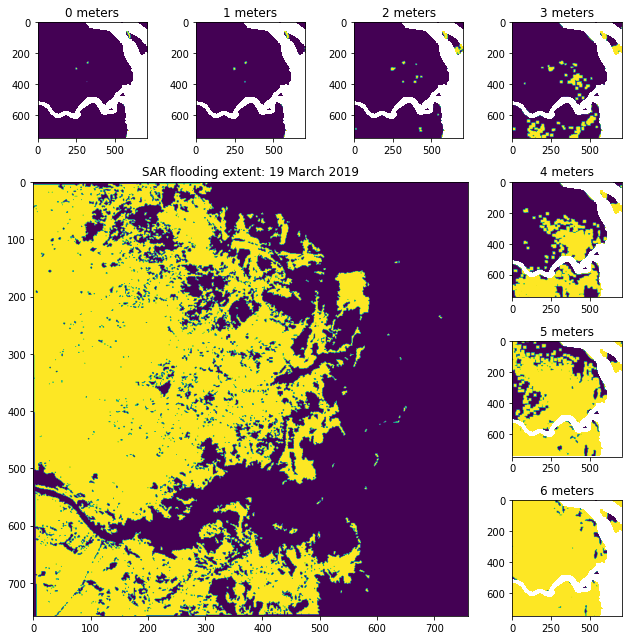

In [48]:

fig = plt.figure(figsize=(9, 9), constrained_layout=False)
a1 = plt.subplot2grid((4,4),(0,0))
a2 = plt.subplot2grid((4,4),(0,1))
a3 = plt.subplot2grid((4,4),(0,2))
a4 = plt.subplot2grid((4,4),(0,3))

a5 = plt.subplot2grid((4,4),(1,0), rowspan = 3, colspan = 3)

a6 = plt.subplot2grid((4,4),(1,3))
a7 = plt.subplot2grid((4,4),(2,3))
a8= plt.subplot2grid((4,4),(3,3))

a1.imshow(new_mask[0].squeeze())
a1.set_title('0 meters')
a2.imshow(new_mask[1].squeeze())
a2.set_title('1 meters')
a3.imshow(new_mask[2].squeeze())
a3.set_title('2 meters')
a4.imshow(new_mask[3].squeeze())
a4.set_title('3 meters')
a5.imshow(arr) #a1.set_title('exp')
#a5.imshow(mask_with90, zorder=2, alpha=0.3)
a5.set_title('SAR flooding extent: 19 March 2019')
a6.imshow(new_mask[4].squeeze())
a6.set_title('4 meters')
a7.imshow(new_mask[5].squeeze())
a7.set_title('5 meters')
a8.imshow(new_mask[6].squeeze())
a8.set_title('6 meters')

#plt.axes.xaxis.set_ticks([])
#plt.axes.yaxis.set_ticks([])
#plt.tick_labels('off')

plt.tight_layout()
plt.show()

<div class="alert alert-block alert-warning"><b>ATTENTION:</b> The 90% WOfS adds context to the flooded coastal area. How to mask the GEE image similarly?</div>

## Drawing conclusions

Here are some questions to think about:
* What can you conclude about the actual level of Inundation? 
* Which sections of the coastal area are likely to be most affected? 
* Is the prediction realistic? How can the prediction be improved?
* What other information might you need to draw additional conclusions about potential problem areas?

## Next steps
When you are done, return to the **Analysis parameters** cell, modify some values (e.g. `lat`/`lon`) and rerun the analysis.

Consider increasing the `buffer` and exploring a larger area without the *computationally expensive* 3D Visualization. 